<a href="https://colab.research.google.com/github/mnbpdx/langgraph-agents/blob/main/initial_api_call_agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# inital api call agent

this agent has a retrieval node that calls an api.


## install dependencies

In [16]:
%pip install --quiet -U langchain_openai langchain_core langgraph langchain-pinecone pinecone-notebooks


[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## set the OpenAI API Key

In [17]:
import os, getpass

def _set_env(var: str):
  if not os.environ.get(var):
    os.environ[var] = getpass.getpass(f"Enter your {var}: ")

_set_env("OPENAI_API_KEY")

## define the LLM model

In [18]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

## define tools

In [19]:
def cozy_day():
  """
  If it looks like it's going to be a cozy inside weather day,
  run this funtion.

  """
  print("cozy day!")

def outside_day():
  """
  If it looks like it's going to be a fun outside weather day,
  run this funtion.
  """
  print("outside day!")

tools = [cozy_day, outside_day]

## bind tools to the LLM

In [20]:
llm_with_tools = llm.bind_tools(tools)

## build the LLM node

In [21]:
from langgraph.graph import MessagesState
from langchain_core.messages import trim_messages

def llm_with_tools_node(state: MessagesState):

  # trim the messages to the last 150 tokens worth
  messages = trim_messages(
      messages=state["messages"],
      strategy="last",
      token_counter=ChatOpenAI(model="gpt-4o-mini"),
      max_tokens=150,
      start_on="human",
      allow_partial=False,
  )

  return {"messages": [llm_with_tools.invoke(messages)]}

## build the retrieval node

In [22]:
from langchain_core.messages import SystemMessage
from main import get_one_day_forecast

def retrieval_node(state: MessagesState):
    weather_related_text_to_pass_llm = get_one_day_forecast()

    # Create a new SystemMessage
    system_message = SystemMessage(content=weather_related_text_to_pass_llm)

    result_message = {"messages": [system_message] + state["messages"]}

    # Return the updated messages state including the new SystemMessage
    return result_message

## build the graph

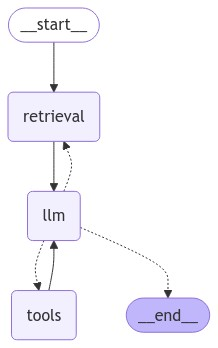

In [23]:
from langgraph.graph import StateGraph, START
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image

builder = StateGraph(MessagesState)

# add nodes
builder.add_node("retrieval", retrieval_node)
builder.add_node("llm", llm_with_tools_node)
builder.add_node("tools", ToolNode(tools))

# connect them (add edges)
builder.add_edge(START, "retrieval")
builder.add_edge("retrieval", "llm")
builder.add_conditional_edges("llm", tools_condition)
builder.add_edge("tools", "llm")

# memory = MemorySaver()
# graph = builder.compile(checkpointer=memory)
graph = builder.compile()

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

## invoke the graph


In [24]:
from langchain_core.messages import HumanMessage

# config = {"configurable": {"thread_id": "1"}}

messages = [HumanMessage(content="what kind of day is it gonna be?")]
messages = graph.invoke(input={"messages": messages})
# messages = graph.invoke(input={"messages": messages}, config=config)

for m in messages['messages']:
    m.pretty_print()

https://api.weather.gov/gridpoints/PQR/152,105/forecast
cozy day!
================================ Human Message =================================

what kind of day is it gonna be?
================================ System Message ================================

Partly cloudy. Low around 47, with temperatures rising to around 49 overnight. West wind around 3 mph.
================================== Ai Message ==================================
Tool Calls:
  cozy_day (call_fMeydY2EVz5MCGOefxbdDnNe)
 Call ID: call_fMeydY2EVz5MCGOefxbdDnNe
  Args:
================================= Tool Message =================================
Name: cozy_day

null
================================== Ai Message ==================================

It looks like it's going to be a cozy inside weather day!


## Alternately, we could pass the weather api in as a tool

(Lets ignore the other tools now)

This way the agent will only get the weather if it needs it.

## build the weather tool

In [37]:
def get_current_weather_tool():
    """
        Use this to get the current weather.
    """
                
    return get_one_day_forecast()

def press_the_button():
    """
        Press a button!
    """

weather_tool = [get_current_weather_tool]

## bind the tool

In [38]:
llm_with_weather_tool = llm.bind_tools(weather_tool)

## build the LLM node

In [54]:
from langgraph.graph import MessagesState
from langchain_core.messages import trim_messages

def llm_with_tools_node(state: MessagesState):

  # trim the messages to the last 150 tokens worth
  messages = trim_messages(
      messages=state["messages"],
      strategy="last",
      token_counter=ChatOpenAI(model="gpt-4o-mini"),
      max_tokens=100,
      start_on="human",
      allow_partial=False,
  )

  return {"messages": [llm_with_weather_tool.invoke(messages)]}

## build the graph

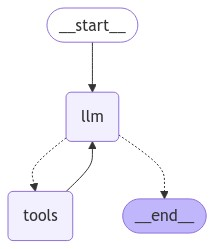

In [55]:
from langgraph.graph import StateGraph, START
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image

builder = StateGraph(MessagesState)

# add nodes
builder.add_node("llm", llm_with_tools_node)
builder.add_node("tools", ToolNode(weather_tool))

# connect them (add edges)
builder.add_edge(START, "llm")
builder.add_conditional_edges("llm", tools_condition)
builder.add_edge("tools", "llm")

graph = builder.compile()

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))